In [56]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np


### Define functions for plotting learning curves, predicted vs. true values, and residuals ###

# Set a consistent plotting style
plt.style.use('seaborn-v0_8-darkgrid')  
plt.rcParams['figure.figsize'] = [10, 6]  # Set a consistent figure size

# Function for plotting learning curves
def plot_learning_curve(model_name, train_sizes, train_scores, validation_scores):
    train_scores_mean = -np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    validation_scores_mean = -np.mean(validation_scores, axis=1)
    validation_scores_std = np.std(validation_scores, axis=1)

    plt.figure()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, validation_scores_mean - validation_scores_std,
                     validation_scores_mean + validation_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training error")
    plt.plot(train_sizes, validation_scores_mean, '^-', color="g", label="Validation error")

    plt.xlabel('Number of Training Examples')
    plt.ylabel('Mean Squared Error (MSE)')
    plt.title(f'{model_name} Learning Curve')
    plt.legend(loc="best")
    plt.show()

# Function for plotting predicted vs. true values
def plot_predicted_vs_true(y_true, y_pred):
    plt.figure()
    plt.scatter(y_true, y_pred, alpha=0.3)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], '--r', linewidth=2)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.title('Predicted vs. True Values')
    plt.show()

# Function for plotting residuals
def plot_residuals(model_name, y_true, y_pred):
    residuals = y_true - y_pred
    plt.figure()
    plt.scatter(y_pred, residuals, alpha=0.3)
    plt.hlines(y=0, xmin=y_pred.min(), xmax=y_pred.max(), linestyles='--')
    plt.xlabel('Predicted')
    plt.ylabel('Residuals')
    plt.title(f'{model_name} Residual Plot')
    plt.show()

# Function to print metrics for a given model
def print_model_metrics(model, model_name, X_test, y_test):
    y_pred = model.predict(X_test)
    if model_name == 'MLP':
        y_pred = y_pred.flatten()  # Flatten to match shape of y_test
    
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    print(f'{model_name} Metrics:')
    print(f'MAE: {mae}')
    print(f'MSE: {mse}')
    print(f'RMSE: {rmse}')
    print(f'R²: {r2}')
    print('-------------------------')

def print_model_params(model, model_name, param_dist):
    param_dist_keys = param_dist.keys()
    best_params = model.get_params()
    print(f'{model_name} optimized hyperarameters:')
    for param in param_dist_keys:
        if param in best_params:
            print(f"{param}: {best_params[param]}")

In [57]:
import pandas as pd

### EDA ###

# Load data
file_path = r'C:\Users\Bruker\OneDrive - NTNU\Y5\Master_thesis\Idun\MachineLearning\Data\diffusion_coefficients_cp_BinSeg_l1.csv'
df_unfiltered = pd.read_csv(file_path)

# Filter out rows where R^2 is less than 0.90
df = df_unfiltered[df_unfiltered['R^2'] >= 0.90]

"""Can be added for less warnings:

df = df.loc[df['R_squared'] >= 0.90]
df.loc[:, 'Concentration'] = df['Concentration'].astype(str)"""

num_rows_unfiltered = df_unfiltered.shape[0]
print(num_rows_unfiltered)

num_rows = df.shape[0]
print(num_rows)

# Display the first few rows of the data
#print(df.head())

# Display the summary statistics of the data
print(df.describe())

# Check for missing values in the data
#print(df.isnull().sum())

# Calculate the variance of the data
print(df.var())

# Calculate the correlation between the features and the target
print(df.corr())

# Scale the Diffusion Coefficient by 10^11, BUT WE NEED TO CALL THIS TRANSFORMATION IN THE PIPELINE
df['Diffusion Coefficient'] = df['Diffusion Coefficient'] * 1e11

# Calculate the variance of the scaled Diffusion Coefficient

print(df['Diffusion Coefficient'].var())

# Calculate correlation matrix between the numeric feature and the target
corr_matrix = df.corr()
print(corr_matrix.loc['Diffusion Coefficient', 'Temperature'])



995
913
       Temperature  Concentration  Diffusion Coefficient         R^2  \
count   913.000000     913.000000           9.130000e+02  913.000000   
mean    307.957954      80.208105           5.248583e-11    0.982678   
std      28.728850      14.336207           4.683504e-11    0.020529   
min     258.000000      66.000000           1.102388e-12    0.900029   
25%     283.225225      66.000000           2.220546e-11    0.976311   
50%     307.749750      75.000000           3.802110e-11    0.990654   
75%     332.774775     100.000000           6.428435e-11    0.996987   
max     358.000000     100.000000           3.702196e-10    0.999904   

           stderr  
count  913.000000  
mean     0.000023  
std      0.000025  
min      0.000001  
25%      0.000009  
50%      0.000016  
75%      0.000027  
max      0.000213  
Temperature              8.253468e+02
Concentration            2.055268e+02
Diffusion Coefficient    2.193521e-21
R^2                      4.214579e-04
stderr     

C:\Users\Bruker\AppData\Local\Temp\ipykernel_46108\2020898998.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Diffusion Coefficient'] = df['Diffusion Coefficient'] * 1e11


In [58]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


#### PREPROCESSING ####

# Convert 'Concentration' to string to ensure it's treated as categorical
df['Concentration'] = df['Concentration'].astype(str)

# Split data into 80% training and 20% test
X = df[['Concentration', 'Temperature']]
y = df['Diffusion Coefficient']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Define preprocessing for numeric columns (scale them)
numeric_features = ['Temperature']
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

# Define preprocessing for categorical features (encode them)
categorical_features = ['Concentration']
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Create preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

C:\Users\Bruker\AppData\Local\Temp\ipykernel_46108\3508237514.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Concentration'] = df['Concentration'].astype(str)


Fitting 5 folds for each of 100 candidates, totalling 500 fits


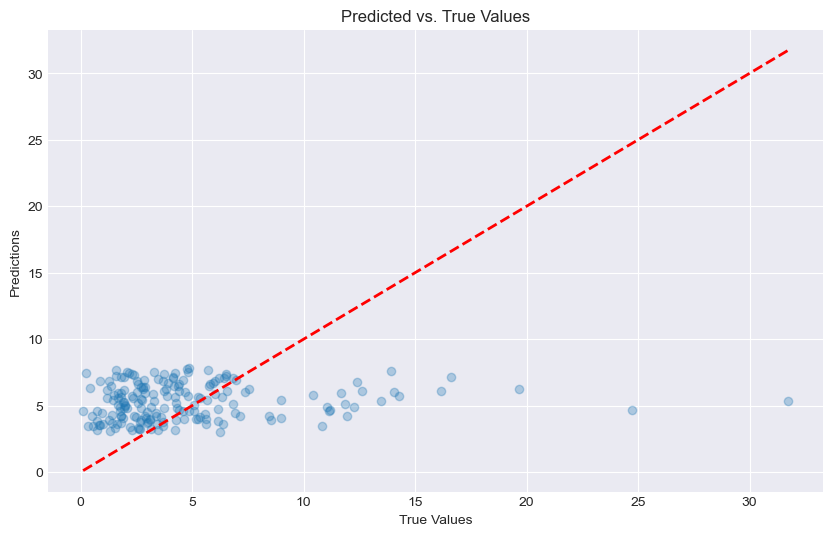

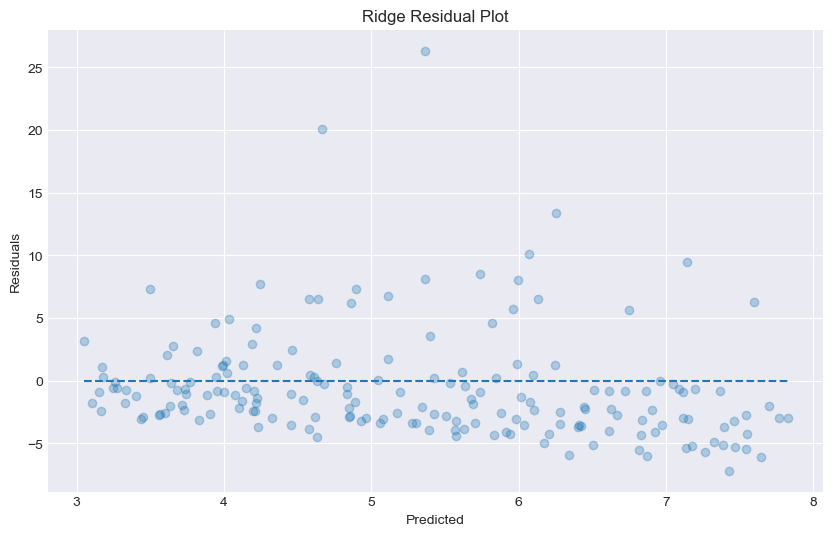

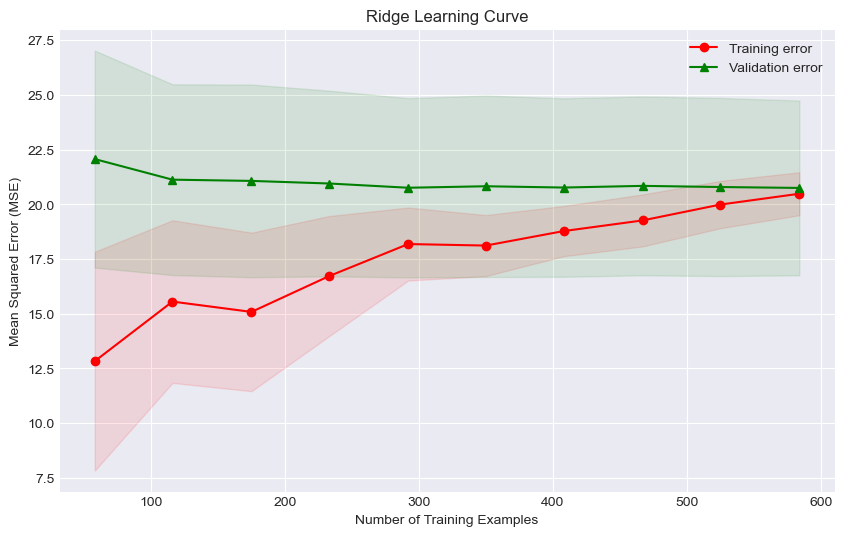

Ridge Metrics:
MAE: 3.128247284160935
MSE: 19.246131894244684
RMSE: 4.387041359987923
R²: -0.04502123016307147
-------------------------
Ridge optimized hyperarameters:
regressor__alpha: 65.3455217139933


In [63]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import learning_curve
from scipy.stats import uniform # REMEMBER that first number is start value (loc) and second (scale) is how far the distribution spans

### RIDGE REGRESSION ###

# Create a preprocessing and modelling pipeline with Ridge regression
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('regressor', Ridge(random_state=0))])



# Define hyperparameter space
param_dist = {
    'regressor__alpha': uniform(0.1, 99.9), # Removed fit_intercept and solver
}

# Perform a randomized search over the hyperparameter space

random_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=100, cv=5, random_state=0, scoring='neg_mean_squared_error', verbose=1)

# Fit the grid search
random_search.fit(X_train, y_train)

# Best model
best_model = random_search.best_estimator_

# Predictions
y_pred = best_model.predict(X_test)

# Generate learning curve data
train_sizes, train_scores, validation_scores = learning_curve(
    estimator=best_model, 
    X=X_train, 
    y=y_train, 
    train_sizes=np.linspace(0.1, 1.0, 10), 
    cv=5, 
    scoring='neg_mean_squared_error', 
    n_jobs=-1
)

# Plotting Prediction vs True Value with Scaled Axes
plot_predicted_vs_true(y_test, y_pred)
# Residuals Plot 
plot_residuals('Ridge', y_test, y_pred)

# Plot Learning Curve
plot_learning_curve('Ridge', train_sizes, train_scores, validation_scores)

# Printing best model metrics
print_model_metrics(best_model, 'Ridge', X_test, y_test)

# Printing best model parameters
print_model_params(best_model, 'Ridge', param_dist)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


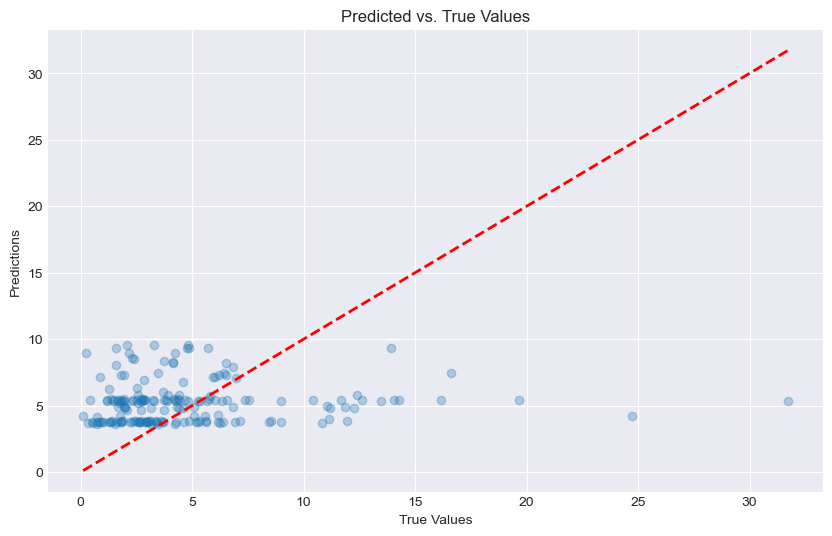

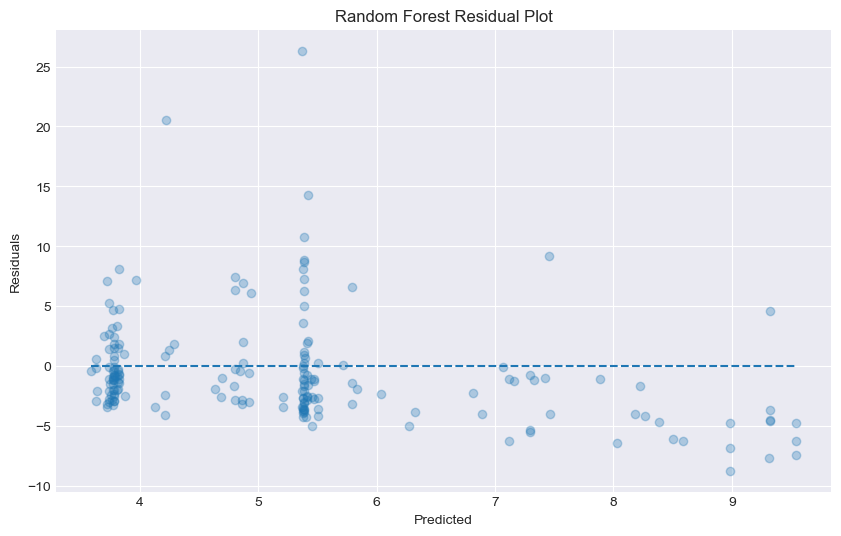

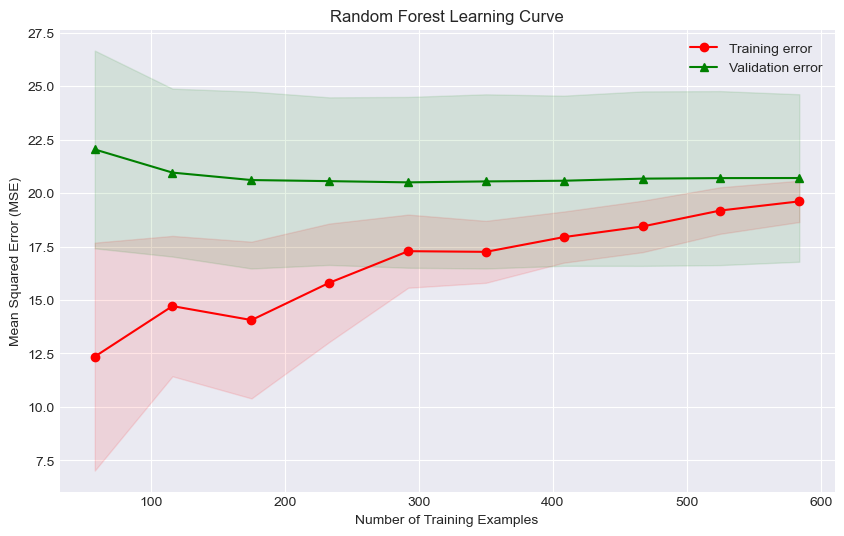

Random Forest Metrics:
MAE: 3.1977371933041985
MSE: 20.421964808396496
RMSE: 4.519066807250861
R²: -0.10886628563526246
-------------------------
Random Forest optimized hyperarameters:
regressor__n_estimators: 301
regressor__max_depth: 2
regressor__min_samples_split: 18
regressor__min_samples_leaf: 18


In [60]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import learning_curve
from scipy.stats import randint

### RANDOM FOREST REGRESSOR ###

# Define the model
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('regressor', RandomForestRegressor(random_state=0))])

# Define hyperparameter space
param_dist = {
    'regressor__n_estimators': randint(10, 1001),
    'regressor__max_depth': randint(1, 51),
    'regressor__min_samples_split': randint(2, 21), #Removed max_features as we only have 2 features for now
    'regressor__min_samples_leaf': randint(1, 21) #Removed bootstrap as it should be True becuase of the size of the dataset
}

# Perform a randomized search over the hyperparameter space
random_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=100, cv=5, random_state=0, scoring='neg_mean_squared_error', verbose=1)

# Fit the random search
random_search.fit(X_train, y_train)

# Best model
best_model = random_search.best_estimator_

# Predictions
y_pred = best_model.predict(X_test)

# Learning Curve
train_sizes, train_scores, validation_scores = learning_curve(
    estimator=best_model,
    X=X_train,
    y=y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1)

# Plotting Prediction vs True Value with Scaled Axes
plot_predicted_vs_true(y_test, y_pred)

# Residuals Plot 
plot_residuals('Random Forest',y_test, y_pred)

# Plot Learning Curve
plot_learning_curve('Random Forest', train_sizes, train_scores, validation_scores)

# Printing best model metrics
print_model_metrics(best_model, 'Random Forest', X_test, y_test)

# Printing best model parameters
print_model_params(best_model, 'Random Forest', param_dist)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


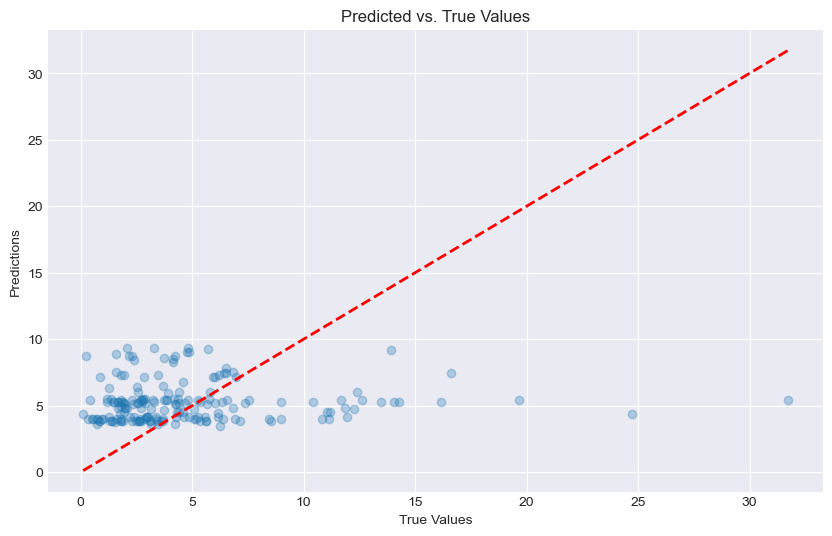

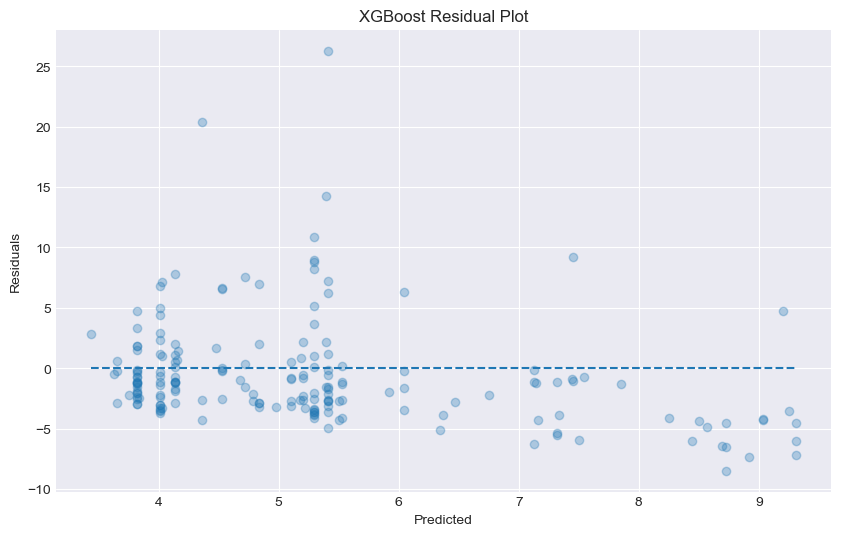

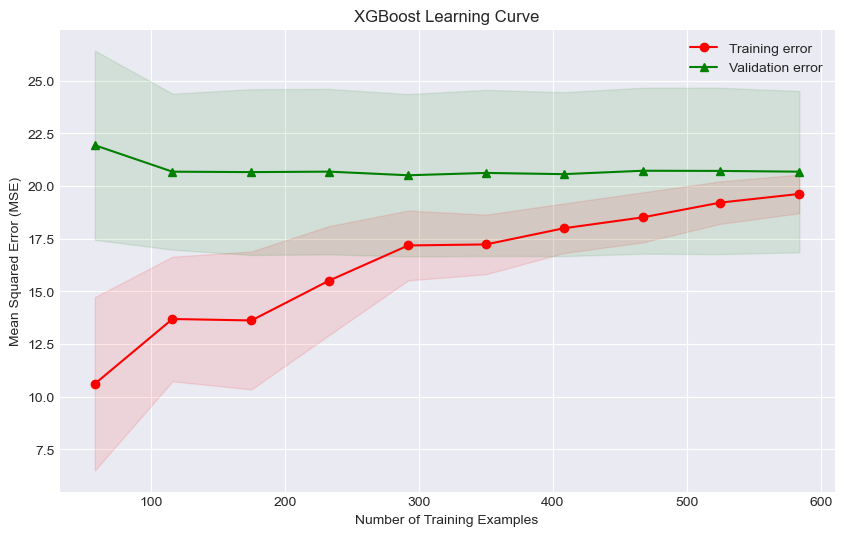

XGBoost Metrics:
MAE: 3.196105396975041
MSE: 20.271397882310147
RMSE: 4.502376914731834
R²: -0.1006908436718994
-------------------------
XGBoost optimized hyperarameters:
regressor__n_estimators: 257
regressor__max_depth: 1
regressor__learning_rate: 0.019345945644411736
regressor__subsample: 0.7892882695782841
regressor__colsample_bytree: 0.9201513848428954
regressor__gamma: 4.3856548294061914


In [61]:
import xgboost as xgb

### XGBOOST REGRESSOR ###

# Define the model
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('regressor', xgb.XGBRegressor(objective='reg:squarederror', random_state=0))])

# Define hyperparameter space
param_dist = {
    'regressor__n_estimators': randint(50, 301),  # 50 to 300 trees
    'regressor__max_depth': randint(1, 5),  # Maximum depth from 1 to 4
    'regressor__learning_rate': uniform(0.01, 0.1),  # Learning rate from 0.01 to 0.11
    'regressor__subsample': uniform(0.6, 0.4),  # Subsample ratio from 0.6 to 1.0
    'regressor__colsample_bytree': uniform(0.6, 0.4),  # Column sample ratio from 0.6 to 1.0
    'regressor__gamma': uniform(0, 5),  # Minimum loss reduction for further splits
}

# Perform a randomized search over the hyperparameter space
random_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=100, cv=5, random_state=0, scoring='neg_mean_squared_error', verbose=1)

# Fit the randomized search
random_search.fit(X_train, y_train)

# Best model
best_model = random_search.best_estimator_

# Predictions
y_pred = best_model.predict(X_test)

# Learning Curve
train_sizes, train_scores, validation_scores = learning_curve(
    estimator=best_model,
    X=X_train,
    y=y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1)

# Plotting Prediction vs True Value with Scaled Axes
plot_predicted_vs_true(y_test, y_pred)

# Residuals Plot 
plot_residuals('XGBoost', y_test, y_pred)

# Plot Learning Curve
plot_learning_curve('XGBoost', train_sizes, train_scores, validation_scores)

# Printing best model metrics
print_model_metrics(best_model, 'XGBoost', X_test, y_test)

# Printing best model parameters
print_model_params(best_model, 'XGBoost', param_dist)

Trial 100 Complete [00h 00m 04s]
val_mean_squared_error: 23.006969451904297

Best val_mean_squared_error So Far: 22.662109375
Total elapsed time: 00h 06m 04s
Epoch 1/100
19/19 [==============================] - 1s 14ms/step - loss: 19.6925 - mean_squared_error: 19.6925 - val_loss: 22.7798 - val_mean_squared_error: 22.7798
Epoch 2/100
19/19 [==============================] - 0s 4ms/step - loss: 19.6772 - mean_squared_error: 19.6772 - val_loss: 22.8293 - val_mean_squared_error: 22.8293
Epoch 3/100
19/19 [==============================] - 0s 4ms/step - loss: 19.7028 - mean_squared_error: 19.7028 - val_loss: 22.8679 - val_mean_squared_error: 22.8679
Epoch 4/100
19/19 [==============================] - 0s 4ms/step - loss: 19.6253 - mean_squared_error: 19.6253 - val_loss: 22.8673 - val_mean_squared_error: 22.8673
Epoch 5/100
19/19 [==============================] - 0s 4ms/step - loss: 19.6481 - mean_squared_error: 19.6481 - val_loss: 22.8075 - val_mean_squared_error: 22.8075
Epoch 6/100
19/1

C:\Users\Bruker\AppData\Local\Temp\ipykernel_46108\1494000596.py:87: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  best_model_wrapped = KerasRegressor(build_fn=build_best_model, epochs=100, batch_size=32, verbose=0)


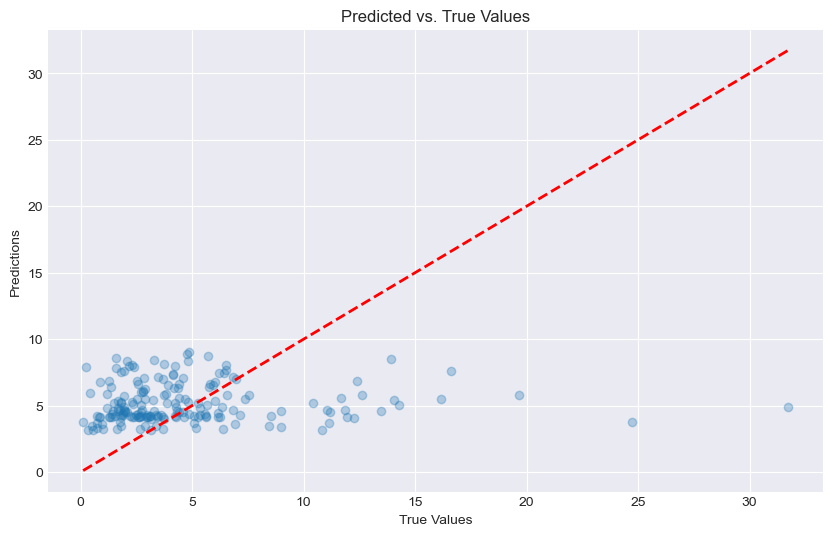

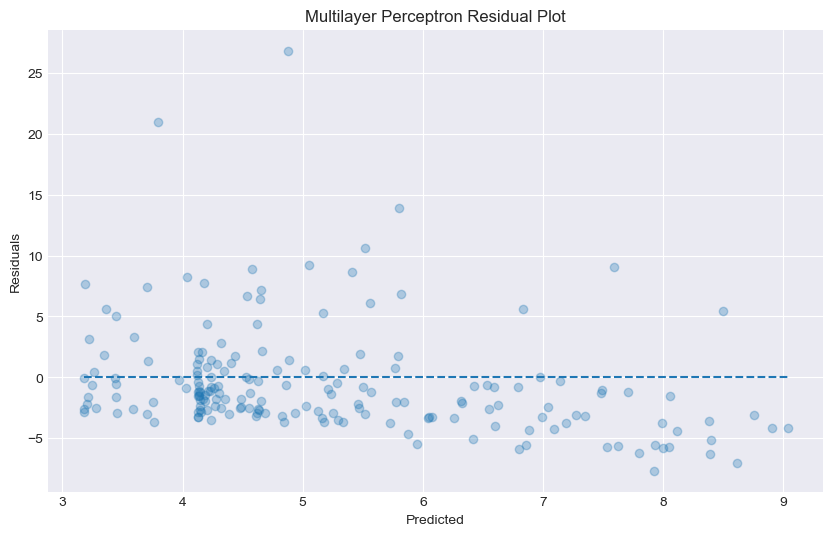

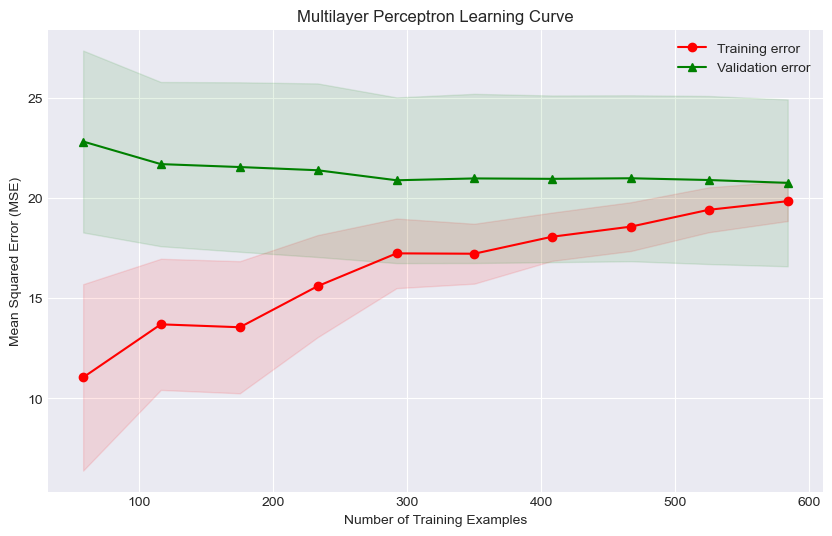

In [67]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner import RandomSearch
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

# Set random seed for reproducibility
np.random.seed(0)
tf.random.set_seed(0)

### MLP REGRESSOR ###

# Apply the preprocessing steps to the training data
X_train_MLP = preprocessor.fit_transform(X_train)
# Apply the preprocessing steps to the test data
X_test_MLP = preprocessor.transform(X_test)

# Step 1: Model-building function
def build_model(hp):
    model = keras.Sequential()
    activation = hp.Choice('activation', values=['relu', 'leaky_relu', 'elu'])
    
    # First layer with unique hyperparameter name
    model.add(layers.Dense(units=hp.Int('units_layer_1', min_value=16, max_value=256, step=16),
                           activation=activation,
                           input_dim=X_train_MLP.shape[1]))
    
    # Second layer with unique hyperparameter name
    model.add(layers.Dense(units=hp.Int('units_layer_2', min_value=16, max_value=256, step=16),
                           activation=activation))
    
    model.add(layers.Dense(1, activation='linear'))
    
    model.compile(optimizer=keras.optimizers.Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')),
                  loss='mean_squared_error',
                  metrics=['mean_squared_error'])
    
    return model

# Step 2: Configure the tuner
tuner = RandomSearch(
    build_model,
    objective='val_mean_squared_error',
    max_trials=100,  # Adjust based on your computational budget
    executions_per_trial=1,  # How many models to build for each trial
    directory='my_dir_Random4',  # Directory to save logs and models
    project_name='keras_tuning',
    seed=0  # Set seed for reproducibility
)

# Step 3: Run the tuner
tuner.search(X_train_MLP, y_train, epochs=30, validation_split=0.2, callbacks=[EarlyStopping(patience=10)])

# Retrieve the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Retrain this model on the full dataset or evaluate it on a test set
history = best_model.fit(X_train_MLP, y_train, validation_split=0.2, epochs=100, batch_size=32, callbacks=[EarlyStopping(patience=10)])

# Print the best parameters from the Keras tuner
print("Best Model Parameters:")
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
for param, value in best_hyperparameters.values.items():
    print(f"{param}: {value}")

# Printing best model metrics
print_model_metrics(best_model, 'MLP', X_test_MLP, y_test)

# Use the best_model directly for predictions
y_pred = best_model.predict(X_test_MLP)
y_pred = y_pred.flatten()  # Flatten to match shape of y_test

# Define build_best_model function
def build_best_model():
    # Clone the model architecture
    model_clone = keras.models.clone_model(best_model)
    # Compile the cloned model with the same configuration as the best_model
    model_clone.compile(optimizer=best_model.optimizer,
                        loss='mean_squared_error',
                        metrics=['mean_squared_error'])
    # Copy the weights from the best_model
    model_clone.set_weights(best_model.get_weights())
    return model_clone

# For learning curve, use the build_best_model function wrapped in KerasRegressor
best_model_wrapped = KerasRegressor(build_fn=build_best_model, epochs=100, batch_size=32, verbose=0)

train_sizes, train_scores, validation_scores = learning_curve(
    estimator=best_model_wrapped, 
    X=X_train_MLP,
    y=y_train, 
    train_sizes=np.linspace(0.1, 1.0, 10), 
    cv=5, 
    scoring='neg_mean_squared_error', 
    n_jobs=1
)

# Plotting Prediction vs True Value with Scaled Axes
plot_predicted_vs_true(y_test, y_pred)

# Residuals Plot 
plot_residuals('Multilayer Perceptron', y_test, y_pred)

# Plot Learning Curve
plot_learning_curve('Multilayer Perceptron', train_sizes, train_scores, validation_scores)